In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (classification_report, confusion_matrix, 
                             roc_auc_score, roc_curve, precision_recall_curve,
                             f1_score, accuracy_score, precision_score, recall_score)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set random seeds
np.random.seed(42)
tf.random.set_seed(42)

LOAD PREPROCESSED DATA

In [3]:
X_train = np.load('X_train.npy')
X_test = np.load('X_test.npy')
y_train = np.load('y_train.npy')
y_test = np.load('y_test.npy')

print(f"Training samples: {X_train.shape[0]}")
print(f"Test samples: {X_test.shape[0]}")
print(f"Number of features: {X_train.shape[1]}")

Training samples: 227845
Test samples: 56962
Number of features: 30


RESHAPE DATA FOR LSTM

In [4]:
# LSTM expects 3D input: (samples, timesteps, features)
# We'll treat each feature as a timestep
X_train_lstm = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_lstm = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print(f"\nReshaped training data: {X_train_lstm.shape}")
print(f"Reshaped test data: {X_test_lstm.shape}")
print(f"Format: (samples, timesteps, features)")


Reshaped training data: (227845, 30, 1)
Reshaped test data: (56962, 30, 1)
Format: (samples, timesteps, features)


BUILD LSTM MODEL

In [5]:
def create_lstm_model(timesteps, features):
    """
    Creates an LSTM model with:
    - 2 LSTM layers for sequential pattern learning
    - Dropout for regularization
    - Dense layers for classification
    - Sigmoid activation for binary output
    """
    model = Sequential([
        # First LSTM layer - returns sequences for next LSTM
        LSTM(64, return_sequences=True, input_shape=(timesteps, features),
             name='lstm_layer_1'),
        Dropout(0.3),
        BatchNormalization(),
        
        # Second LSTM layer - returns final output
        LSTM(32, return_sequences=False, name='lstm_layer_2'),
        Dropout(0.3),
        BatchNormalization(),
        
        # Dense layers for classification
        Dense(16, activation='relu', name='dense_layer_1'),
        Dropout(0.2),
        
        Dense(8, activation='relu', name='dense_layer_2'),
        
        # Output layer
        Dense(1, activation='sigmoid', name='output_layer')
    ])
    
    return model

In [6]:
# Create model
timesteps = X_train_lstm.shape[1]
features = X_train_lstm.shape[2]
model = create_lstm_model(timesteps, features)


In [7]:
# Display model architecture
print("\nLSTM Model Architecture:")
model.summary()


LSTM Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_layer_1 (LSTM)                  │ (None, 30, 64)              │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 30, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 30, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_layer_2 (LSTM)                  │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_layer_1 (Dense)                │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_layer_2 (Dense)                │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,369 (118.63 KB)

 Trainable params: 30,177 (117.88 KB)

 Non-trainable params: 192 (768.00 B)

COMPILE MODEL

In [8]:
# Calculate class weights
neg_count = len(y_train) - y_train.sum()
pos_count = y_train.sum()
total = len(y_train)

weight_for_0 = (1 / neg_count) * (total / 2.0)
weight_for_1 = (1 / pos_count) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print(f"\nClass weights:")
print(f"Normal transactions (0): {weight_for_0:.4f}")
print(f"Fraud transactions (1): {weight_for_1:.4f}")


Class weights:
Normal transactions (0): 0.5009
Fraud transactions (1): 289.1434


In [9]:
# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')
    ]
)

SETUP CALLBACKS

In [10]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=0.00001,
    verbose=1
)

checkpoint = ModelCheckpoint(
    'lstm_best_model.h5',
    monitor='val_auc',
    mode='max',
    save_best_only=True,
    verbose=1
)

callbacks = [early_stop, reduce_lr, checkpoint]

TRAIN MODEL

In [11]:
history = model.fit(
    X_train_lstm, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=256,
    class_weight=class_weight,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50
713/713 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.8778 - auc: 0.8991 - loss: 0.3687 - precision: 0.0131 - recall: 0.8049
Epoch 1: val_auc improved from None to 0.95010, saving model to lstm_best_model.h5


713/713 ━━━━━━━━━━━━━━━━━━━━ 36s 44ms/step - accuracy: 0.9164 - auc: 0.9197 - loss: 0.3290 - precision: 0.0168 - recall: 0.8360 - val_accuracy: 0.9771 - val_auc: 0.9501 - val_loss: 0.1395 - val_precision: 0.0637 - val_recall: 0.8434 - learning_rate: 0.0010
Epoch 2/50
712/713 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9486 - auc: 0.9452 - loss: 0.2593 - precision: 0.0299 - recall: 0.8811
Epoch 2: val_auc improved from 0.95010 to 0.95130, saving model to lstm_best_model.h5


713/713 ━━━━━━━━━━━━━━━━━━━━ 32s 44ms/step - accuracy: 0.9545 - auc: 0.9432 - loss: 0.2699 - precision: 0.0314 - recall: 0.8585 - val_accuracy: 0.9650 - val_auc: 0.9513 - val_loss: 0.2530 - val_precision: 0.0441 - val_recall: 0.8795 - learning_rate: 0.0010
Epoch 3/50
713/713 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9298 - auc: 0.9565 - loss: 0.2497 - precision: 0.0228 - recall: 0.8874
Epoch 3: val_auc improved from 0.95130 to 0.95242, saving model to lstm_best_model.h5


713/713 ━━━━━━━━━━━━━━━━━━━━ 32s 44ms/step - accuracy: 0.9499 - auc: 0.9510 - loss: 0.2561 - precision: 0.0288 - recall: 0.8682 - val_accuracy: 0.9736 - val_auc: 0.9524 - val_loss: 0.1603 - val_precision: 0.0576 - val_recall: 0.8795 - learning_rate: 0.0010
Epoch 4/50
713/713 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9593 - auc: 0.9523 - loss: 0.2343 - precision: 0.0374 - recall: 0.8828
Epoch 4: val_auc did not improve from 0.95242
713/713 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.9653 - auc: 0.9460 - loss: 0.2525 - precision: 0.0409 - recall: 0.8617 - val_accuracy: 0.9777 - val_auc: 0.9452 - val_loss: 0.2230 - val_precision: 0.0653 - val_recall: 0.8434 - learning_rate: 0.0010
Epoch 5/50
712/713 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9719 - auc: 0.9584 - loss: 0.2224 - precision: 0.0532 - recall: 0.8687
Epoch 5: val_auc did not improve from 0.95242
713/713 ━━━━━━━━━━━━━━━━━━━━ 31s 44ms/step - accuracy: 0.9698 - auc: 0.9503 - loss: 0.2403 - precision: 0.0464 - recal

713/713 ━━━━━━━━━━━━━━━━━━━━ 32s 44ms/step - accuracy: 0.9759 - auc: 0.9548 - loss: 0.2257 - precision: 0.0578 - recall: 0.8585 - val_accuracy: 0.9894 - val_auc: 0.9599 - val_loss: 0.1325 - val_precision: 0.1326 - val_recall: 0.8675 - learning_rate: 5.0000e-04
Epoch 8/50
713/713 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9808 - auc: 0.9669 - loss: 0.1880 - precision: 0.0764 - recall: 0.8857
Epoch 8: val_auc did not improve from 0.95991
713/713 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.9819 - auc: 0.9612 - loss: 0.2065 - precision: 0.0764 - recall: 0.8650 - val_accuracy: 0.9831 - val_auc: 0.9559 - val_loss: 0.1863 - val_precision: 0.0857 - val_recall: 0.8554 - learning_rate: 5.0000e-04
Epoch 9/50
713/713 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9710 - auc: 0.9718 - loss: 0.1815 - precision: 0.0534 - recall: 0.9073
Epoch 9: val_auc did not improve from 0.95991
713/713 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.9726 - auc: 0.9634 - loss: 0.2054 - precision: 0.0522

713/713 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.9750 - auc: 0.9621 - loss: 0.2087 - precision: 0.0565 - recall: 0.8714 - val_accuracy: 0.9902 - val_auc: 0.9600 - val_loss: 0.1558 - val_precision: 0.1420 - val_recall: 0.8675 - learning_rate: 5.0000e-04
Epoch 11/50
713/713 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.9786 - auc: 0.9738 - loss: 0.1697 - precision: 0.0716 - recall: 0.9099
Epoch 11: val_auc improved from 0.95996 to 0.96114, saving model to lstm_best_model.h5


713/713 ━━━━━━━━━━━━━━━━━━━━ 32s 46ms/step - accuracy: 0.9816 - auc: 0.9689 - loss: 0.1934 - precision: 0.0755 - recall: 0.8682 - val_accuracy: 0.9869 - val_auc: 0.9611 - val_loss: 0.1269 - val_precision: 0.1096 - val_recall: 0.8675 - learning_rate: 5.0000e-04
Epoch 12/50
713/713 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9632 - auc: 0.9752 - loss: 0.1747 - precision: 0.0424 - recall: 0.9055
Epoch 12: val_auc improved from 0.96114 to 0.96174, saving model to lstm_best_model.h5


713/713 ━━━━━━━━━━━━━━━━━━━━ 33s 46ms/step - accuracy: 0.9691 - auc: 0.9676 - loss: 0.1977 - precision: 0.0464 - recall: 0.8746 - val_accuracy: 0.9832 - val_auc: 0.9617 - val_loss: 0.1603 - val_precision: 0.0882 - val_recall: 0.8795 - learning_rate: 5.0000e-04
Epoch 13/50
712/713 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9751 - auc: 0.9780 - loss: 0.1559 - precision: 0.0625 - recall: 0.9112
Epoch 13: val_auc did not improve from 0.96174
713/713 ━━━━━━━━━━━━━━━━━━━━ 33s 46ms/step - accuracy: 0.9791 - auc: 0.9713 - loss: 0.1824 - precision: 0.0681 - recall: 0.8875 - val_accuracy: 0.9793 - val_auc: 0.9564 - val_loss: 0.1772 - val_precision: 0.0718 - val_recall: 0.8675 - learning_rate: 5.0000e-04
Epoch 14/50
713/713 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9776 - auc: 0.9771 - loss: 0.1565 - precision: 0.0691 - recall: 0.9185
Epoch 14: val_auc improved from 0.96174 to 0.96369, saving model to lstm_best_model.h5


713/713 ━━━━━━━━━━━━━━━━━━━━ 34s 47ms/step - accuracy: 0.9825 - auc: 0.9691 - loss: 0.1862 - precision: 0.0807 - recall: 0.8875 - val_accuracy: 0.9896 - val_auc: 0.9637 - val_loss: 0.1402 - val_precision: 0.1348 - val_recall: 0.8675 - learning_rate: 5.0000e-04
Epoch 15/50
713/713 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9775 - auc: 0.9702 - loss: 0.1785 - precision: 0.0676 - recall: 0.9085
Epoch 15: val_auc improved from 0.96369 to 0.96398, saving model to lstm_best_model.h5


713/713 ━━━━━━━━━━━━━━━━━━━━ 33s 47ms/step - accuracy: 0.9784 - auc: 0.9687 - loss: 0.1910 - precision: 0.0660 - recall: 0.8875 - val_accuracy: 0.9847 - val_auc: 0.9640 - val_loss: 0.1413 - val_precision: 0.0952 - val_recall: 0.8675 - learning_rate: 5.0000e-04
Epoch 16/50
712/713 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9772 - auc: 0.9781 - loss: 0.1574 - precision: 0.0663 - recall: 0.9049
Epoch 16: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 16: val_auc did not improve from 0.96398
713/713 ━━━━━━━━━━━━━━━━━━━━ 33s 47ms/step - accuracy: 0.9790 - auc: 0.9715 - loss: 0.1853 - precision: 0.0666 - recall: 0.8714 - val_accuracy: 0.9680 - val_auc: 0.9582 - val_loss: 0.1968 - val_precision: 0.0473 - val_recall: 0.8675 - learning_rate: 5.0000e-04
Epoch 17/50
712/713 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9773 - auc: 0.9762 - loss: 0.1631 - precision: 0.0679 - recall: 0.9135
Epoch 17: val_auc did not improve from 0.96398
713/713 ━━━━━━━━━━━━━━━━━━━━

713/713 ━━━━━━━━━━━━━━━━━━━━ 34s 47ms/step - accuracy: 0.9814 - auc: 0.9800 - loss: 0.1591 - precision: 0.0768 - recall: 0.8971 - val_accuracy: 0.9905 - val_auc: 0.9662 - val_loss: 0.1064 - val_precision: 0.1452 - val_recall: 0.8675 - learning_rate: 2.5000e-04
Epoch 21/50
713/713 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9811 - auc: 0.9846 - loss: 0.1309 - precision: 0.0799 - recall: 0.9163
Epoch 21: val_auc did not improve from 0.96621
713/713 ━━━━━━━━━━━━━━━━━━━━ 34s 47ms/step - accuracy: 0.9809 - auc: 0.9791 - loss: 0.1602 - precision: 0.0745 - recall: 0.8939 - val_accuracy: 0.9897 - val_auc: 0.9587 - val_loss: 0.1206 - val_precision: 0.1361 - val_recall: 0.8675 - learning_rate: 2.5000e-04
Epoch 22/50
712/713 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9805 - auc: 0.9848 - loss: 0.1240 - precision: 0.0792 - recall: 0.9427
Epoch 22: val_auc did not improve from 0.96621
713/713 ━━━━━━━━━━━━━━━━━━━━ 34s 48ms/step - accuracy: 0.9809 - auc: 0.9810 - loss: 0.1505 - precision: 0.

PLOT TRAINING HISTORY

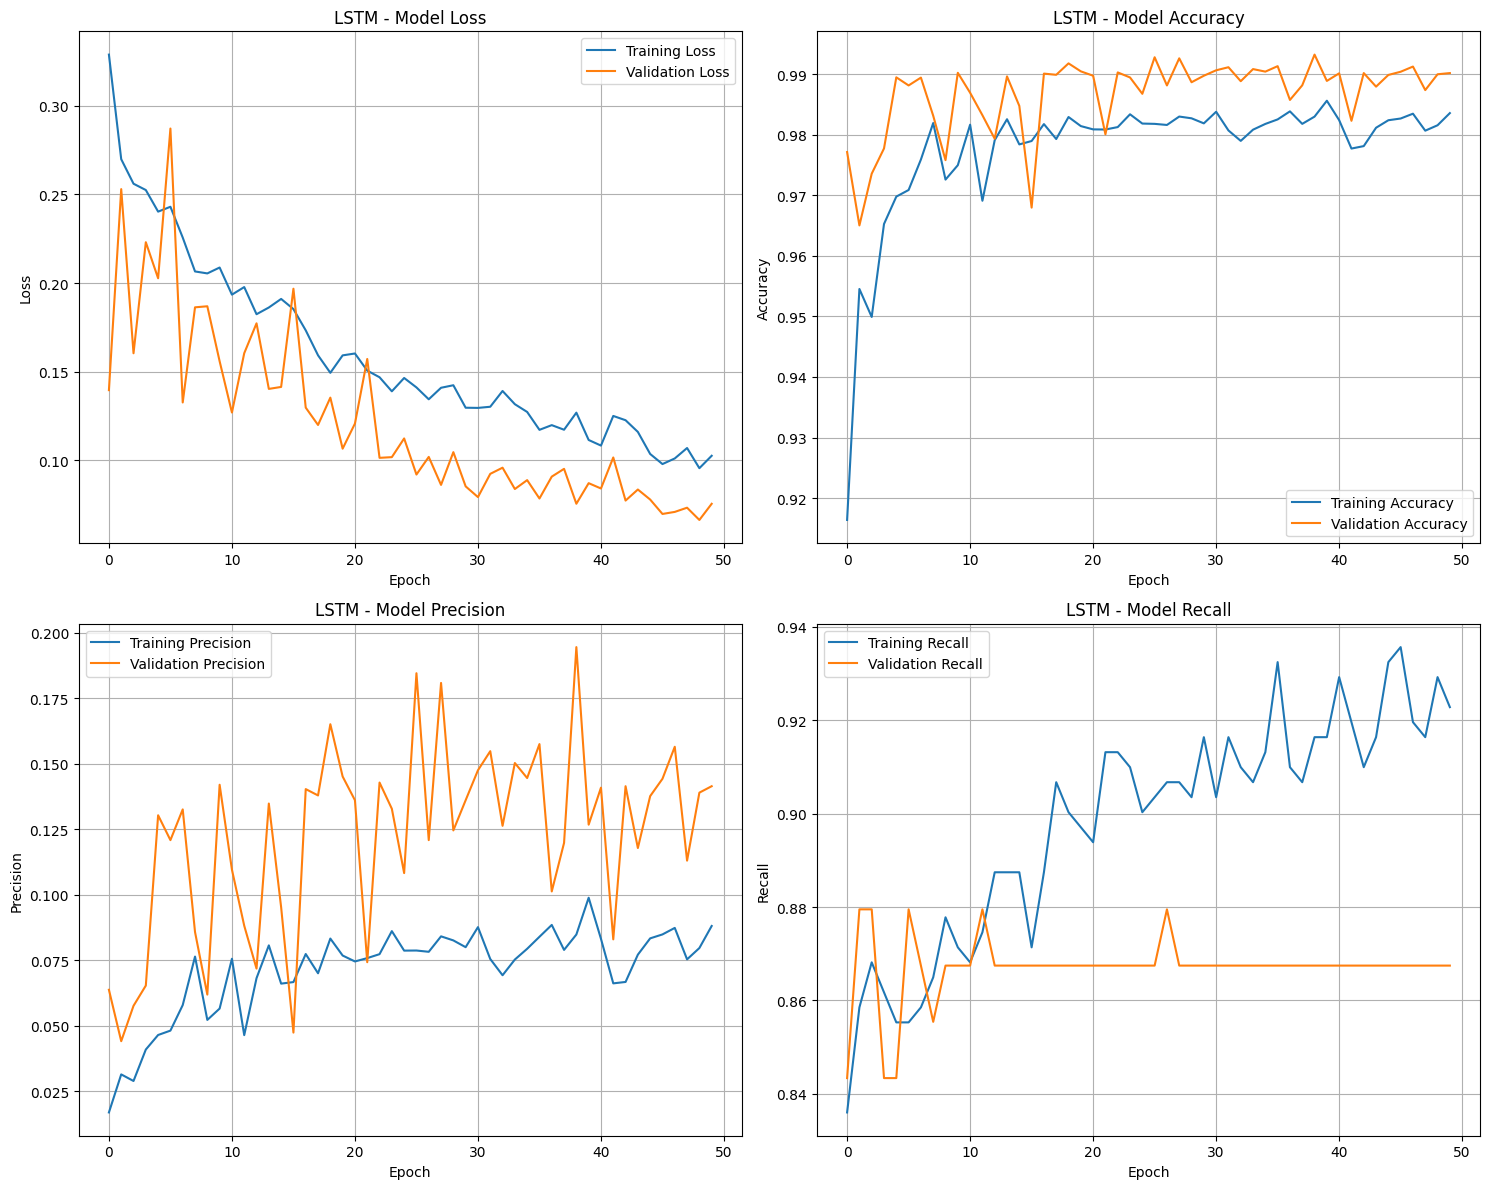

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Loss
axes[0, 0].plot(history.history['loss'], label='Training Loss')
axes[0, 0].plot(history.history['val_loss'], label='Validation Loss')
axes[0, 0].set_title('LSTM - Model Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Accuracy
axes[0, 1].plot(history.history['accuracy'], label='Training Accuracy')
axes[0, 1].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[0, 1].set_title('LSTM - Model Accuracy')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Precision
axes[1, 0].plot(history.history['precision'], label='Training Precision')
axes[1, 0].plot(history.history['val_precision'], label='Validation Precision')
axes[1, 0].set_title('LSTM - Model Precision')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Precision')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Recall
axes[1, 1].plot(history.history['recall'], label='Training Recall')
axes[1, 1].plot(history.history['val_recall'], label='Validation Recall')
axes[1, 1].set_title('LSTM - Model Recall')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Recall')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.savefig('lstm_training_history.png', dpi=300, bbox_inches='tight')
plt.show()

EVALUATE MODEL

In [13]:
# Predictions
y_pred_prob = model.predict(X_test_lstm, verbose=0)
y_pred = (y_pred_prob > 0.5).astype(int)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_prob)

print(f"\nTest Set Performance:")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")
print(f"ROC-AUC:   {auc:.4f}")


Test Set Performance:
Accuracy:  0.9887
Precision: 0.1205
Recall:    0.8878
F1-Score:  0.2122
ROC-AUC:   0.9628
